In [1]:
with open('sample_name.txt','r') as f:
    name = f.read().split("\n")
    name_dict = {}
    for i in name:
        key, value = i.split(":")
        name_dict[key] = value
    number_of_samples = len(name_dict)

# 資料預處理

In [2]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,      #x坐标保持不变，而对应的y坐标按比例发生平移
                                   zoom_range = 0.2,       #可以让图片在长或宽的方向进行放大
                                   horizontal_flip = True) #水平翻转操作
validation_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen = ImageDataGenerator(rescale = 1./255)

Using TensorFlow backend.


In [3]:
training_set = train_datagen.flow_from_directory('trainset/', target_size = (64, 64), batch_size = 10,
                                                 class_mode = 'categorical')
validation_set = validation_datagen.flow_from_directory('validationset/', target_size = (64, 64), batch_size = 10, 
                                                        class_mode = 'categorical')
test_set = test_datagen.flow_from_directory('testset/', target_size = (64, 64), batch_size = 10, 
                                            class_mode = 'categorical')

Found 204 images belonging to 3 classes.
Found 52 images belonging to 3 classes.
Found 66 images belonging to 3 classes.


# 建立模型

In [4]:
from keras.models import Sequential 
from keras.layers import Conv2D
from keras.layers import MaxPooling2D 
from keras.layers import Flatten
from keras.layers import Dense

classifier = Sequential() # Initialising the CNN
classifier.add(Conv2D(32, (3, 3), input_shape = (64, 64, 3), activation = 'relu')) # Convolution
classifier.add(MaxPooling2D(pool_size = (2, 2))) # Max Pooling
classifier.add(Conv2D(32, (3, 3), activation = 'relu')) # Convolution
classifier.add(MaxPooling2D(pool_size = (2, 2))) # Max Pooling
classifier.add(Flatten()) # Flattening
classifier.add(Dense(units = 128, activation = 'relu')) # Fully Connected
classifier.add(Dense(units = 128, activation = 'relu'))
classifier.add(Dense(units = number_of_samples, activation = 'softmax'))
classifier.compile(optimizer = 'adam', loss ='categorical_crossentropy', metrics = ['accuracy'])

# 訓練模型

In [5]:
# try:
#     classifier.load_weights("SaveModel/face.h5")
#     print("載入模型成功!繼續訓練模型")
# except :    
#     print("載入模型失敗!開始訓練一個新模型")

In [6]:
history = classifier.fit_generator(training_set,
                                   nb_epoch=20,
                                   nb_val_samples=30,
                                   steps_per_epoch = 30,
                                   verbose = 1,
                                   validation_data = validation_set)

C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  
C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras.pre..., steps_per_epoch=30, verbose=1, validation_data=<keras.pre..., epochs=20, validation_steps=30)`
  


Epoch 1/20
30/30 [==============================] - 2s 78ms/step - loss: 0.5493 - acc: 0.7768 - val_loss: 0.0077 - val_acc: 1.0000
Epoch 2/20
30/30 [==============================] - 2s 58ms/step - loss: 0.3138 - acc: 0.9154 - val_loss: 0.0337 - val_acc: 0.9808
Epoch 3/20
30/30 [==============================] - 2s 65ms/step - loss: 0.0160 - acc: 0.9967 - val_loss: 0.0047 - val_acc: 1.0000
Epoch 4/20
30/30 [==============================] - 2s 61ms/step - loss: 0.0059 - acc: 1.0000 - val_loss: 0.0123 - val_acc: 1.0000
Epoch 5/20
30/30 [==============================] - 2s 61ms/step - loss: 0.0022 - acc: 1.0000 - val_loss: 0.0025 - val_acc: 1.0000
Epoch 6/20
30/30 [==============================] - 2s 61ms/step - loss: 0.0030 - acc: 1.0000 - val_loss: 6.4117e-04 - val_acc: 1.0000
Epoch 7/20
30/30 [==============================] - 2s 64ms/step - loss: 0.0605 - acc: 0.9900 - val_loss: 0.0434 - val_acc: 0.9808
Epoch 8/20
30/30 [==============================] - 2s 65ms/step - loss: 0.0222

# 驗證曲線

In [7]:
import matplotlib.pyplot as plt
def show_train_history(train_acc,test_acc):
    plt.plot(history.history[train_acc])
    plt.plot(history.history[test_acc])
    plt.title('Train History')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

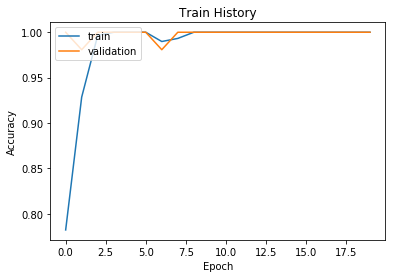

In [8]:
show_train_history('acc','val_acc')

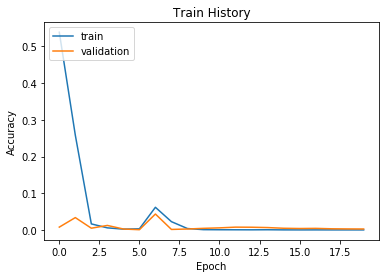

In [9]:
show_train_history('loss','val_loss')

# 模型預測

In [10]:
import numpy as np
from keras.preprocessing import image
test_image = image.load_img(r'sample0_face\sample0_0.png', target_size= (64,64))
test_image = image.img_to_array(test_image)
test_image.shape

(64, 64, 3)

In [11]:
test_image = np.expand_dims(test_image, axis = 0)
type(test_image)
test_image.shape

(1, 64, 64, 3)

In [12]:
classifier.predict_classes(test_image)

array([0], dtype=int64)

In [13]:
name_dict['sample'+str(classifier.predict_classes(test_image)[0])] 

'luokuofeng'

# 評估模型

In [14]:
import os

testset_path = []   #testset_path為所有testset圖片路徑的list
for i in os.listdir('testset'):
    for j in os.listdir('testset/'+i):
        testset_path.append('testset/'+i+'/'+j)   

In [23]:
x_test_image = []
for path in testset_path:
    x_test_image.append(image.img_to_array(image.load_img(path, target_size= (64,64))))
x_test_image = np.array(x_test_image)/225

In [24]:
prediction = classifier.predict_classes(x_test_image)               #預測

In [25]:
from keras.utils import np_utils
y_test_label = test_set.classes
y_Test_OneHot = np_utils.to_categorical(y_test_label)

In [26]:
scores = classifier.evaluate(x_test_image, y_Test_OneHot, verbose=0)  #評估
scores[1]

1.0

# 混淆矩陣

In [27]:
import pandas as pd
pd.crosstab(y_test_label,prediction,rownames=['label'],colnames=['predict'])

predict,0,1,2
label,,,
0,15,0,0
1,0,23,0
2,0,0,28


# 儲存模型

In [20]:
import os

if not os.path.exists('SaveModel'):
    os.mkdir('SaveModel')
classifier.save_weights("SaveModel/face.h5")
print("Saved model to disk")

Saved model to disk
